IBM Data Science Capstone Project

Description of the problem:
Music genres allow characterization of music to facilitate discussion by providing descriptive language regarding the music, helping musicians and industry personnel to understand audience preferences and listening habits and affects the creation and marketing of music.

Successful classification of music by genre can provide help build pertinent recommendation systems to help music providers create playlists or streaming services which match the consumer's tastes and expectations.  Many of these systems are based upon comparison of user's tastes but, for the purposes of this project, I chose to use Spotify music audio features exclusively to attempt to build a multi-classification system. 

The metrics provided by Spotify are shown below.  Please see Spotify documentation for more specific details.

    danceability - suitability for dancing based upon tempo, rhythm, beat and other factors.  Scale: 0.0 - 1.0
    energy - perceptual measure of intensity and activity. Scale: 0.0 - 1.0
    key - estimated overall key of track.  Scale: integer
    loudness - the overall loudness of a track in decibels (dB).  This value will be converted to scalar 0.0-1.0
    speechiness - detects the presence of spoken words in a track. . Scale: 0.0-1.0
    acousticness - overall acousticness of track.  Most tracks are have low acousticness.  Scale: 0.0-1.0
    instrumentalness - predicts whether a track contains no vocals. Scale: 0.0-1.0
    liveness - detects the presence of an audience in the recording. Scale: 0.0-1.0
    valence - describing the musical positiveness conveyed by a track.  Higher values are 'happier'.  Scale: 0.0-1.0
    tempo - overall estimated tempo of a track in beats per minute (BPM).  This value will be converted to a scalar 0.0-1.0

The analysis will compare the audio features of each genre to try to identify distinquishing characteristics, determine overlap between genres and build classification models to assign genre information.

Description of data set and methodology to solve the problem:

Analysis of music genres using data from Every Noise at Once, everynoise.com, a site dedicated to tracking music genres and Spotify API to extract audio features from various songs.  While everynoise tracks thousands of genres, the following list of genres were chosen for this analysis:

    Alternative Rock
    Country
    Dance Pop
    Hip Hop
    Pop
    R&B
    Rock
    
Everynoise creates Spotify playlists associated with each genre listed.  Using the Spotify API, the associated playlist names were found on Spotify, verified as being created by 'The Sound of Spotify', the user name of everynoise on Spotify.

Everynoise creates playlists on Spotify for most of the genres the show on the website.  Using the Spotify API, the pertinent playlists for the genres listed above were identified and the meta data for each track was saved to a csv file.  After data cleanup and pre-processing, approxmately 5100 tracks were identified for the study.  

Using the saved csv file and the Spotify API, the audio features listed above were queried, converted from json format and saved as csv file.  Csv files of the data were saved at various points in the analysis to preclude the neccessity of gerneating the data each time.  The two sets of data (meta and audio features) were joined into a single data frame and saved as a csv.

Some pre-processing was required, although many of the metrics used where already scalar, but some of the remaining metrics were converted to scalar values.  After clean-up, several data visualizations were generated to help obtain a sense of the data.  From this review, several metrics were identified as key indicators such as "energy", "tempo", "loudness", "danceability".  Seperate OneVSRest dataframes were created and plotted against each of these key metrics.  

As a multi-classification project, four models were selected for evaluation 
    K Nearest Neighbor (knn)
    Decision Tree (tree)
    Support Vector Machine (svm)
    Logristic OnevsRest (log)
    
The data was split into a train and test set with 20% of the data reserved for testing.  Each model was measured against a metric function which printed the confusion matrix, printed other metrics and a classification report.  The data was also saved to a dataframe and ultimatley concatenated into a single data frame capturing all metrics.

A K Means Clustering model was also applied against the same training and test data to see how the data itself would drive clustering without regard to pre-defined genre labels.  This data was compared to the original genre data.


Step 1
Import Libraries and intitialize access to Spotify which requires authorization with most API access commands.

In [2]:
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import json
from spotipy.oauth2 import SpotifyClientCredentials
import sp_auth as sa

def authorize_sp():
    cid = sa.cid
    secret = sa.secret
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    spot = spotipy.Spotify(client_credentials_manager
    =
    client_credentials_manager)
    return spot

# Authorize spotify for Hackrdog & test sp_get_artist.
sp = authorize_sp()

In [5]:
# Find Spotify playlist ID for the playlists specified in unique_playlists.  Save output to csv for next stage.
unique_playlists = ['Alternative Rock','Country','Dance Pop','Hip Hop','Pop','R&B','Rock']
s_root = 'The Sound of '
iter_max = len(unique_playlists)
playlist = []
for i in range(iter_max):
    s = s_root+unique_playlists[i]
    r = sp.search(s, type='playlist')
    ri = r['playlists']['items']
    owner = 'thesoundsofspotify'
    for j in range(len(ri)):
        if ri[j]['owner']['id'] in owner:
            playlist.append({'name': ri[j]['name'], 'uri': ri[j]['uri']})
df_out = pd.DataFrame(playlist)
#df_out.to_excel('unique_spid.xlsx', index = False)
df_out

,name,genre,uri,id
0,The Sound of Alternative Rock,Alternative Rock,spotify:playlist:3dlw4x21qVajwZLPNHtS3u,3dlw4x21qVajwZLPNHtS3u
1,The Sound of Country,Country,spotify:playlist:4mijVkpSXJziPiOrK7YX4M,4mijVkpSXJziPiOrK7YX4M
2,The Sound of Dance Pop,Dance Pop,spotify:playlist:2ZIRxkFuqNPMnlY7vL54uK,2ZIRxkFuqNPMnlY7vL54uK
3,The Sound of Hip Hop,Hip Hop,spotify:playlist:6MXkE0uYF4XwU4VTtyrpfP,6MXkE0uYF4XwU4VTtyrpfP
4,The Sound of Pop,Pop,spotify:playlist:6gS3HhOiI17QNojjPuPzqc,6gS3HhOiI17QNojjPuPzqc
5,The Sound of R&B,R&B,spotify:playlist:1rLnwJimWCmjp3f0mEbnkY,1rLnwJimWCmjp3f0mEbnkY
6,The Sound of Rock,Rock,spotify:playlist:7dowgSWOmvdpwNkGFMUs6e,7dowgSWOmvdpwNkGFMUs6e


Use Spotify playlist_ids to extract track meta data from each playlist.  
Meta data will be saved to csv for later processing

In [17]:
#Reads playlist ids from .../spotify playlist uri.xsls, extracts data from spotify, converts to df and saves .csv
# Spotify return paginated results.  The following function appends each page data and returns complete data set.
def sp_parse_page(page):
    items = []
    items.extend(page['items'])
    while page['next']:
        page = sp.next(page)
        items.extend(page['items'])
    return(items)

spf = 'unique_spid.xlsx'
pids_df = pd.read_excel(spf)
pids = pids_df.id.unique().tolist()
genres = pids_df.genre.unique().tolist()
counter = 0
max_iter = 1
tracks = []
for i in range(len(pids)):
    r = sp.playlist(pids[i])
    print(r['name'])
    genre = genres[i]
    t = sp_parse_page(r['tracks'])
    for j in range(len(t)):
        track = t[j]['track']['name']
        artist = t[j]['track']['album']['artists'][0]['name']
        spid = t[j]['track']['id']
        d = {'artist': artist, 'track': track, 'genre': genre, 'id': spid}
        tracks.append(d)
df = pd.DataFrame(tracks)
df.to_csv('everynoise_tracks.csv', index = False)
df    

The Sound of Alternative Rock
The Sound of Country
The Sound of Dance Pop
The Sound of Hip Hop
The Sound of Pop
The Sound of R&B
The Sound of Rock


,artist,track,genre,id
0,Pixies,Where Is My Mind?,Alternative Rock,6mcxQ1Y3uQRU0IHsvdNLH1
1,The Breeders,Cannonball,Alternative Rock,2hjGuRIEfEGzQ5MEWLowiU
2,Dinosaur Jr.,Feel the Pain,Alternative Rock,28c4nfBHdb3xviamRCEsIe
3,Pavement,Harness Your Hopes - (B-side),Alternative Rock,4tggZyGJMNJMooWuRbvN5q
4,Sonic Youth,Teen Age Riot (Album Version),Alternative Rock,0WIbzDVEpmOyBnqqdtqIL9
...,...,...,...,...
6352,INXS,Don't Change,Rock,2j7z87EnqB1NFQts2db0VR
6353,Iggy Pop,The Passenger,Rock,24FmdHoCr2jZGE6Z6dZbJT
6354,Band Of Skulls,Asleep At The Wheel,Rock,4xCKq3dKWEzivqV4jbz9MC
6355,The Fratellis,Henrietta,Rock,69h2mpzNUmdEg5egeNa1ki


The following code retrieves billboard yearend chart data and merges the meta data with the 

Import necessary libraries to process data from Spotify API

In [16]:
import time
import random

def sp_get_audio_feat(id):
    data = sp.audio_features(id)
    return data[0]

t = pd.read_csv('everynoise_tracks.csv')
max_iter = len(t)
denom = float(max_iter)
sleep_itr = 100
audio = []
for i in range(max_iter):
    pct = i/denom
    spid = t.iloc[i]['id']
    r = sp_get_audio_feat(spid)
    audio.append(r)
    if (i % sleep_itr == 0) & (i != 0):
        print('Counter = ', i, 'Sleeping 5 seconds')
        time.sleep(3)
audio_df = pd.DataFrame(audio)
cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
    'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'duration_ms', 'time_signature']
audio_df = audio_df[cols]
audio_df.to_csv('everynoise_audio_feat.csv', index = False)
audio_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,6mcxQ1Y3uQRU0IHsvdNLH1,236973,4
1,0.502,0.758,3,-9.760,1,0.0407,0.009150,0.783000,0.2840,0.729,112.508,2hjGuRIEfEGzQ5MEWLowiU,213693,4
2,0.605,0.573,2,-7.804,1,0.0370,0.289000,0.040600,0.1330,0.581,107.882,4tggZyGJMNJMooWuRbvN5q,206947,4
3,0.340,0.804,0,-8.355,1,0.0516,0.003310,0.019100,0.0727,0.854,131.500,28c4nfBHdb3xviamRCEsIe,259600,4
4,0.286,0.907,7,-9.670,1,0.0374,0.000277,0.202000,0.0837,0.746,156.395,0WIbzDVEpmOyBnqqdtqIL9,417800,4
5,0.494,0.936,11,-7.195,0,0.0398,0.011200,0.000693,0.2760,0.834,107.543,5EugXICXL06waHgP4iTI58,224480,4
6,0.767,0.787,3,-9.897,1,0.0331,0.016300,0.583000,0.0513,0.964,126.879,5QLHGv0DfpeXLNFo7SFEy1,266200,4
7,0.647,0.690,6,-8.657,0,0.0454,0.022400,0.000000,0.1470,0.682,117.514,14g6foD6sxO1qgkDKuPgWv,233573,4
8,0.495,0.840,9,-6.613,1,0.0446,0.130000,0.001510,0.1850,0.478,111.820,3KZVWVH4epY2JGaqRs8bqg,220533,4
9,0.726,0.537,0,-8.896,1,0.1130,0.316000,0.000000,0.0707,0.887,96.910,2ugghimAssmeO3YpFIV7mb,145707,4


Final step in data preparation is to join the meta data with the analytic data to start analyzing results.

In [19]:
# load both csv files and join into one consolidated data file.
meta = pd.read_csv('everynoise_tracks.csv')
print(meta.shape)
audio = pd.read_csv('everynoise_audio_feat.csv')
print(audio.shape)
final_data = meta.join(audio.set_index('id'), on = 'id', how='inner')
final_data

(6344, 4)
(9442, 14)


,artist,track,genre,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Pixies,Where Is My Mind?,Alternative Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
0,Pixies,Where Is My Mind?,Alternative Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
5256,Pixies,Where Is My Mind?,Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
5256,Pixies,Where Is My Mind?,Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
1,The Breeders,Cannonball,Alternative Rock,2hjGuRIEfEGzQ5MEWLowiU,0.502,0.758,3,-9.760,1,0.0407,0.009150,0.783000,0.2840,0.729,112.508,213693,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6340,INXS,Don't Change,Rock,2j7z87EnqB1NFQts2db0VR,0.206,0.810,9,-6.492,1,0.0423,0.000059,0.064400,0.0855,0.155,163.552,268200,4
6341,Little Feat,Long Distance Love,Rock,64lIUwQx1vwo4PIrS5jYb1,0.792,0.289,7,-11.851,1,0.0580,0.640000,0.002110,0.1080,0.355,113.618,163307,4
6341,Little Feat,Long Distance Love,Rock,64lIUwQx1vwo4PIrS5jYb1,0.792,0.289,7,-11.851,1,0.0580,0.640000,0.002110,0.1080,0.355,113.618,163307,4
6342,Band Of Skulls,Asleep At The Wheel,Rock,4xCKq3dKWEzivqV4jbz9MC,0.339,0.669,10,-5.396,1,0.0343,0.000318,0.008830,0.1200,0.636,146.671,246101,4


In [20]:
final_data.drop_duplicates(subset = ['id','genre'], keep = 'first', inplace = True)
final_data.to_csv('interim_data.csv', index = False)
final_data

,artist,track,genre,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Pixies,Where Is My Mind?,Alternative Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
5256,Pixies,Where Is My Mind?,Rock,6mcxQ1Y3uQRU0IHsvdNLH1,0.518,0.436,4,-14.134,1,0.0349,0.015700,0.000621,0.0790,0.270,80.880,236973,4
1,The Breeders,Cannonball,Alternative Rock,2hjGuRIEfEGzQ5MEWLowiU,0.502,0.758,3,-9.760,1,0.0407,0.009150,0.783000,0.2840,0.729,112.508,213693,4
5750,The Breeders,Cannonball,Rock,2hjGuRIEfEGzQ5MEWLowiU,0.502,0.758,3,-9.760,1,0.0407,0.009150,0.783000,0.2840,0.729,112.508,213693,4
2,Dinosaur Jr.,Feel the Pain,Alternative Rock,28c4nfBHdb3xviamRCEsIe,0.340,0.804,0,-8.355,1,0.0516,0.003310,0.019100,0.0727,0.854,131.500,259600,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6339,Frank Zappa,Uncle Remus,Rock,4PPwkLq2ld1k09Bl5NkyZB,0.484,0.660,0,-11.163,1,0.0358,0.034000,0.081200,0.0893,0.742,78.591,169600,4
6340,INXS,Don't Change,Rock,2j7z87EnqB1NFQts2db0VR,0.206,0.810,9,-6.492,1,0.0423,0.000059,0.064400,0.0855,0.155,163.552,268200,4
6341,Little Feat,Long Distance Love,Rock,64lIUwQx1vwo4PIrS5jYb1,0.792,0.289,7,-11.851,1,0.0580,0.640000,0.002110,0.1080,0.355,113.618,163307,4
6342,Band Of Skulls,Asleep At The Wheel,Rock,4xCKq3dKWEzivqV4jbz9MC,0.339,0.669,10,-5.396,1,0.0343,0.000318,0.008830,0.1200,0.636,146.671,246101,4


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix
%matplotlib inline
#print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

In [4]:
#Read data
df = pd.read_csv("final_data.csv")
#Normalize loudness and tempo.  ALl other metrics are already normalized
#df['loudness'] = df['loudness'].apply(lambda x: (x-df['loudness'].min())/(df['loudness'].max()-df['loudness'].min()))
#df['tempo'] = df['tempo'].apply(lambda x: (x-df['tempo'].min())/(df['tempo'].max()-df['tempo'].min()))

genres = df.genre.unique().tolist()
specific = ["energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
df_means = pd.DataFrame(index = genres, columns = specific)
for item in genres:
    for metric in specific:
        genre_df = df[(df['genre'] == item)]
        df_means.loc[item,metric] = genre_df[metric].mean()

df_means

,energy,liveness,tempo,valence,loudness,speechiness,acousticness,danceability,instrumentalness
Dance Pop,0.698526,0.175791,0.441852,0.567787,0.746211,0.080057,0.152656,0.671757,0.0158974
Country,0.619126,0.1642,0.468332,0.570899,0.663574,0.0388086,0.285192,0.58933,0.00184319
Hip Hop,0.672725,0.215747,0.379366,0.601794,0.674387,0.225596,0.143004,0.750496,0.0179862
Alternative Rock,0.715664,0.183746,0.475549,0.51482,0.653595,0.0526215,0.134299,0.47952,0.157626
Pop,0.564664,0.154855,0.442264,0.441975,0.704842,0.0805802,0.339964,0.631561,0.00669734
Rock,0.707787,0.19247,0.480947,0.549244,0.648662,0.0539329,0.16242,0.507603,0.0581687
R&B,0.566994,0.15641,0.406671,0.536849,0.663046,0.0901539,0.235481,0.67405,0.00335494


Separate df into genre-based dataframes for plotting

In [18]:
print(genres)
"""
genres = ['Alternative Rock', 'Rock','Dance Pop', 'Country', 'Pop', 'R&B','Hip Hop']
"""
data_alt = df[df['genre'] =='Alternative Rock']
data_rock = df[df['genre'] =='Rock']
data_hiphop = df[df['genre'] =='Hip Hop']
data_dance = df[df['genre'] =='Dance Pop']
data_country = df[df['genre'] =='Country']
data_pop = df[df['genre'] == 'Pop']
data_randb = df[df['genre'] == 'R&B']


['Alternative Rock', 'Country', 'Dance Pop', 'Hip Hop', 'Pop', 'R&B', 'Rock']


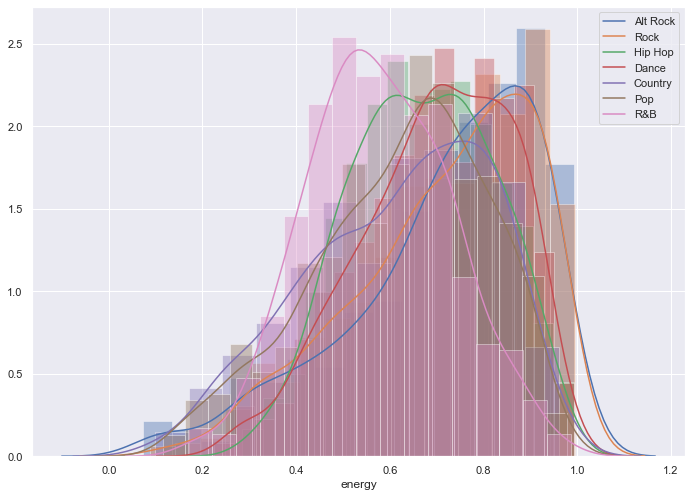

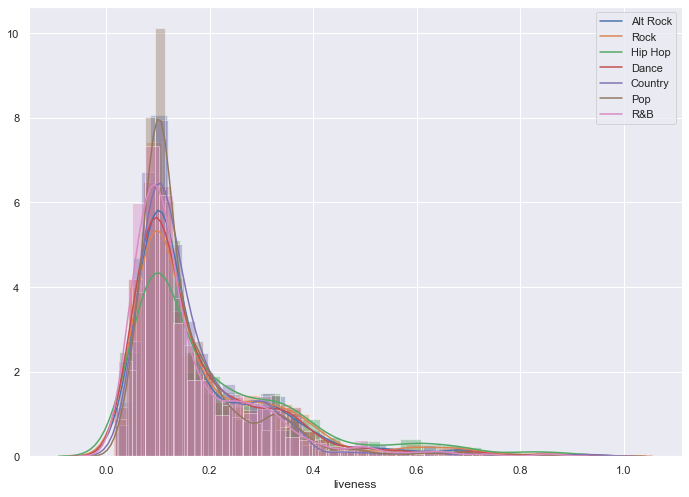

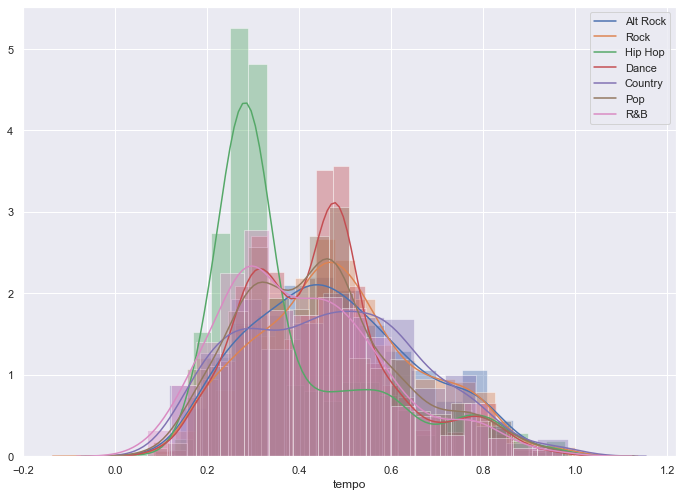

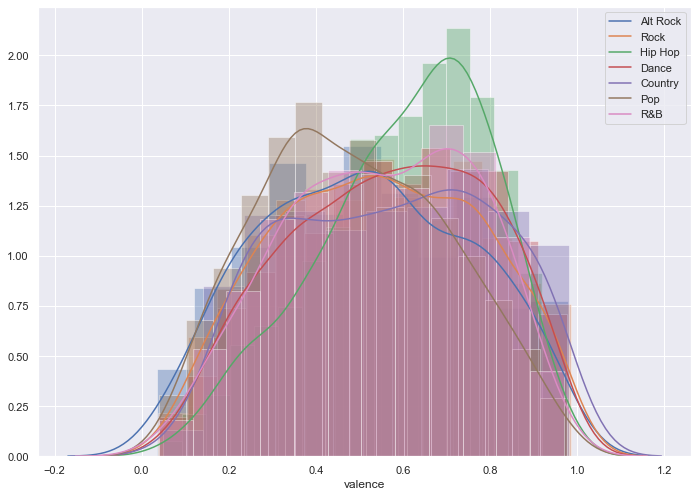

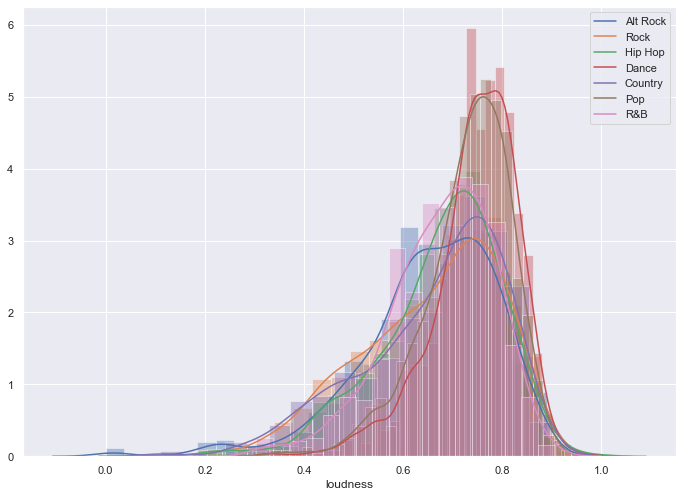

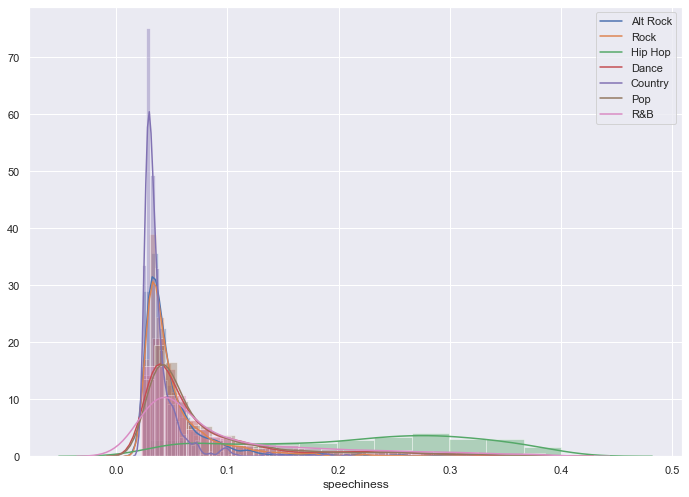

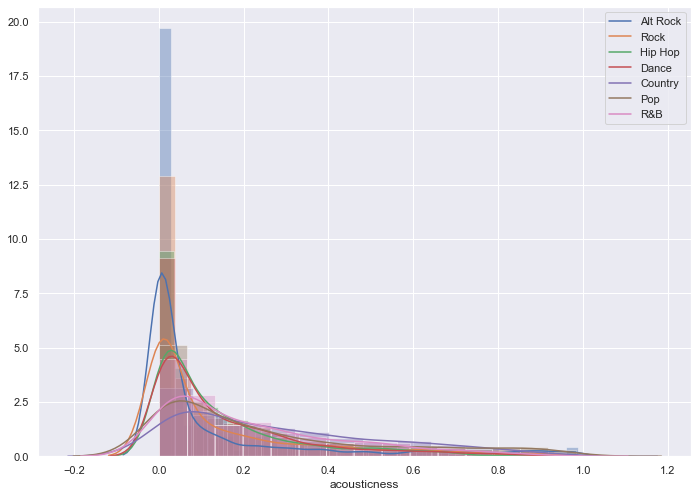

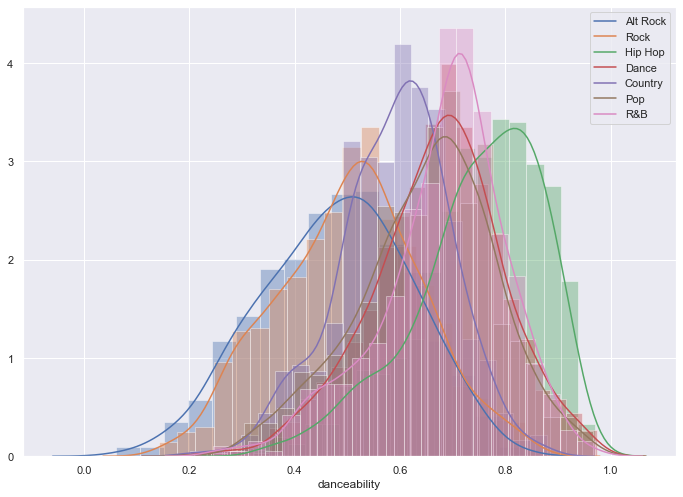

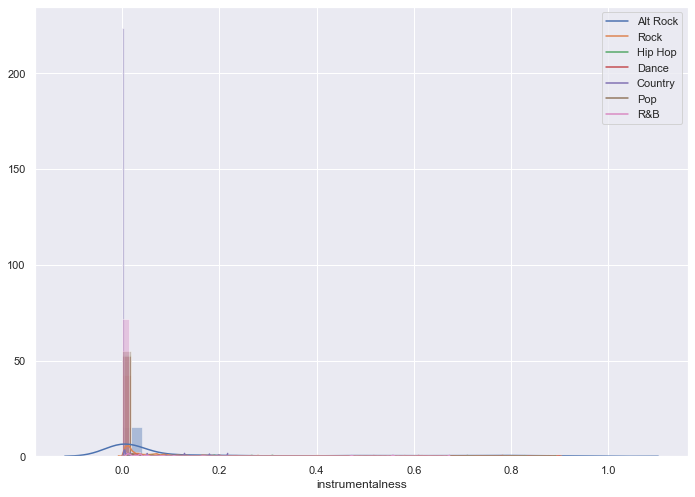

In [30]:
def plot_all(metric):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title = metric
    sns.distplot(data_alt[metric], kde_kws={"label": "Alt Rock"})
    sns.distplot(data_rock[metric], kde_kws={"label": "Rock"})
    sns.distplot(data_hiphop[metric], kde_kws={"label": "Hip Hop"})
    sns.distplot(data_dance[metric], kde_kws={"label": "Dance"})
    sns.distplot(data_country[metric], kde_kws={"label": "Country"})
    sns.distplot(data_pop[metric], kde_kws={"label": "Pop"})
    sns.distplot(data_randb[metric], kde_kws={"label": "R&B"})
    plt.savefig('all_plot_'+metric+'.png')
    plt.show()

for metric in specific:
    plot_all(metric)

df (5141, 11) Alternative Rock (693, 11) others (4448, 11)


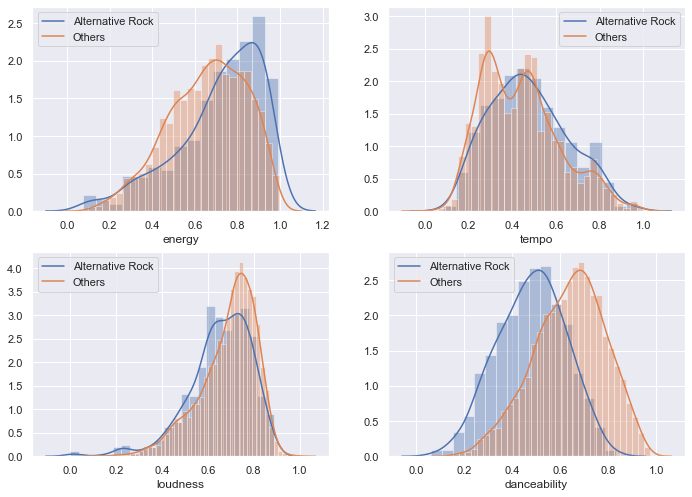

df (5141, 11) Rock (927, 11) others (4214, 11)


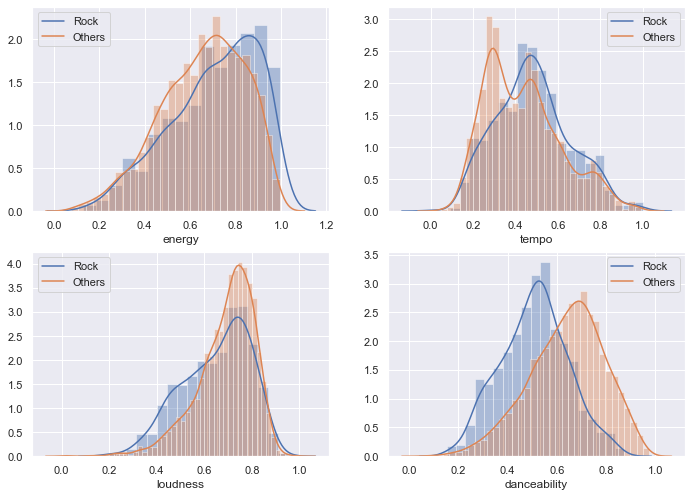

df (5141, 11) Dance Pop (1145, 11) others (3996, 11)


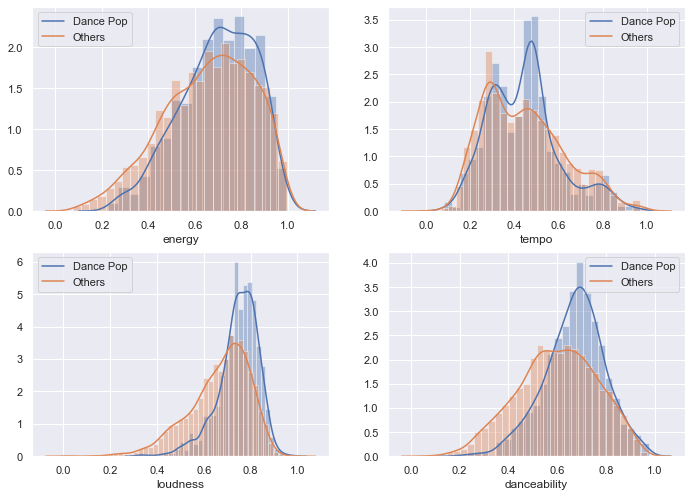

df (5141, 11) Country (569, 11) others (4572, 11)


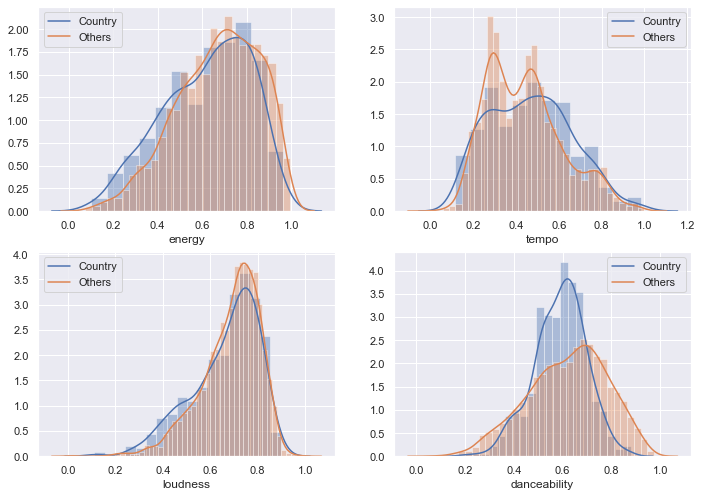

df (5141, 11) Pop (556, 11) others (4585, 11)


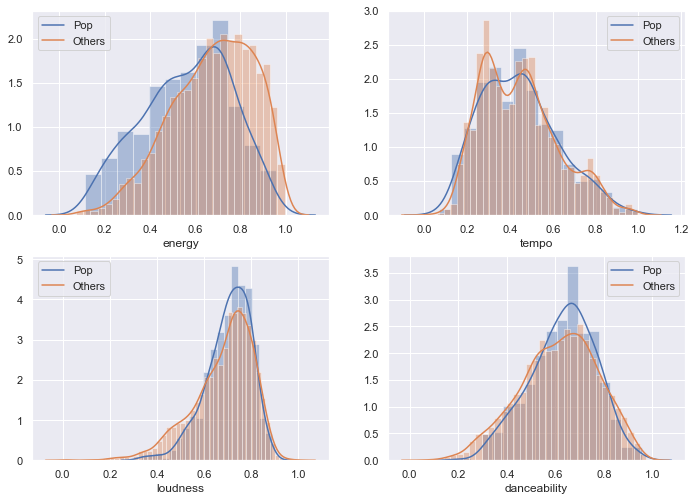

df (5141, 11) R&B (360, 11) others (4781, 11)


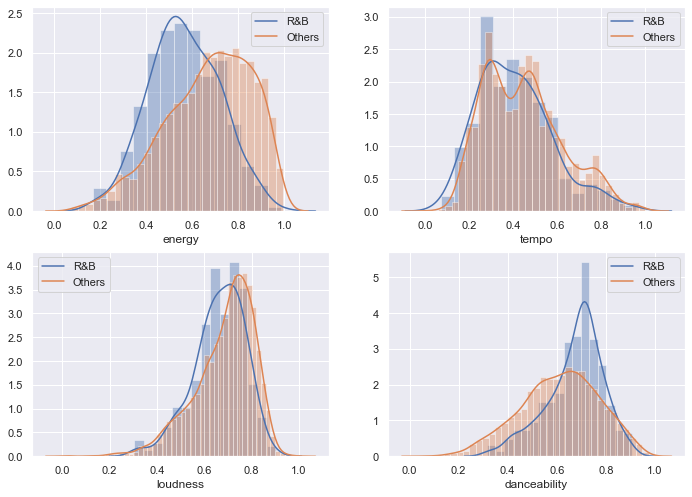

df (5141, 11) Hip Hop (891, 11) others (4250, 11)


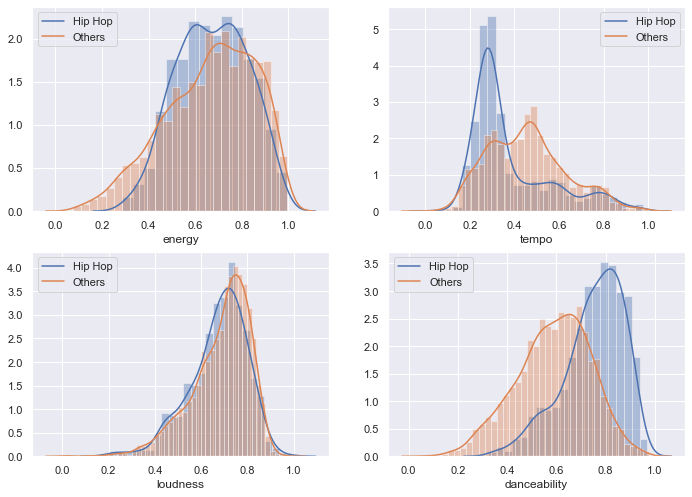

In [115]:
def genre_plot(df, genre, metrics):
    data_genre = df[df['genre'] == genre]
    all_others = df[df['genre'] != genre]
    print('df',df.shape, genre, data_genre.shape, 'others', all_others.shape)
    
    fig, axs = plt.subplots(2, 2)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.distplot(data_genre[metrics[0]], kde_kws={"label": genre}, ax=axs[0,0])
    sns.distplot(all_others[metrics[0]], kde_kws={"label": 'Others'}, ax=axs[0,0])
    sns.distplot(data_genre[metrics[1]], kde_kws={"label": genre}, ax=axs[0,1])
    sns.distplot(all_others[metrics[1]], kde_kws={"label": 'Others'}, ax=axs[0,1])
    sns.distplot(data_genre[metrics[2]], kde_kws={"label": genre}, ax=axs[1,0])
    sns.distplot(all_others[metrics[2]], kde_kws={"label": 'Others'}, ax=axs[1,0])
    sns.distplot(data_genre[metrics[3]], kde_kws={"label": genre}, ax=axs[1,1])
    sns.distplot(all_others[metrics[3]], kde_kws={"label": 'Others'}, ax=axs[1,1])
    plt.savefig('genre_'+genre+'.png')
    plt.show()

    return
    
genres_list = ['Alternative Rock', 'Rock','Dance Pop', 'Country', 'Pop', 'R&B','Hip Hop']
four_metrics = ["energy", "tempo", "loudness", "danceability"]
df_metric_plot = pd.read_csv('final_data.csv', index_col = 'id')

for genre in genres_list:
    genre_plot(df_metric_plot, genre, four_metrics)


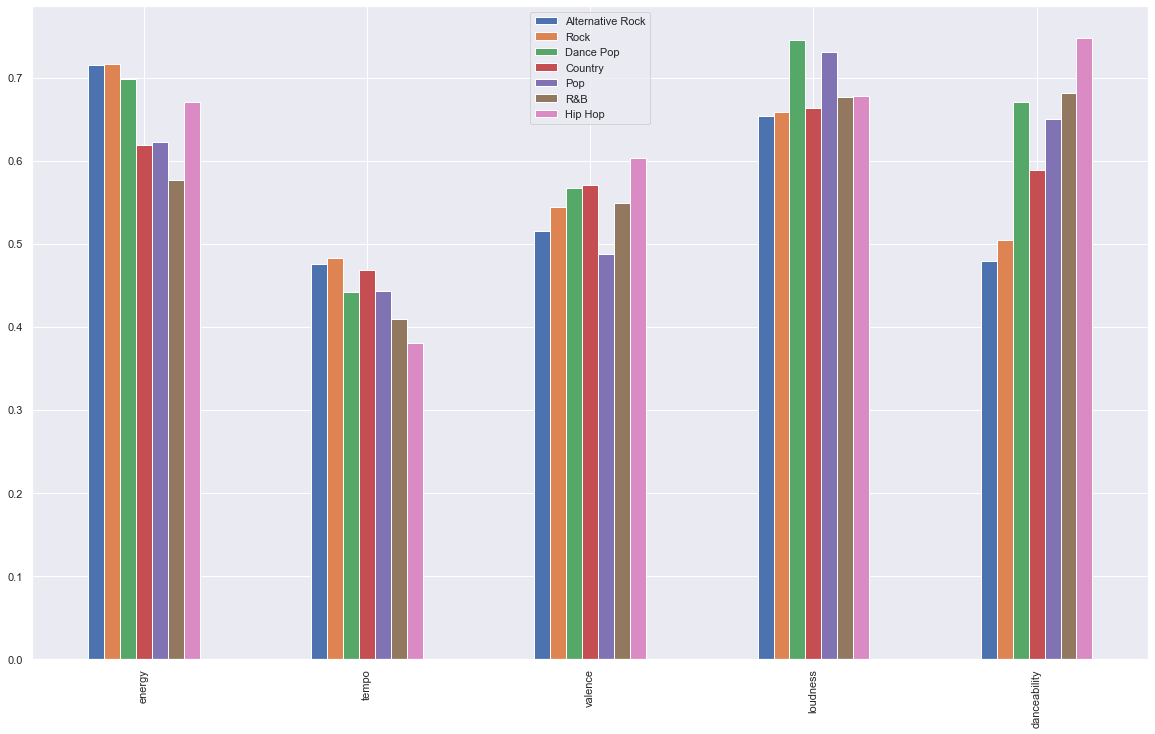

In [31]:
key_metrics = ["energy", "tempo", "valence", "loudness", "danceability"]
df_means = df_means.filter(key_metrics, axis=1)
df_means_x = df_means.transpose()
df_means_x.plot(kind='bar', figsize=(20, 12))
plt.show()

Get data ready for modeling

In [5]:
from sklearn.preprocessing import LabelEncoder
#Reload final data and prepare for model development
df = pd.read_csv("interim_data.csv")
df = df.drop_duplicates(subset=['id'], keep = 'first')
#Normalize loudness and tempo.  ALl other metrics are already normalized
df['loudness'] = df['loudness'].apply(lambda x: (x-df['loudness'].min())/(df['loudness'].max()-df['loudness'].min()))
df['tempo'] = df['tempo'].apply(lambda x: (x-df['tempo'].min())/(df['tempo'].max()-df['tempo'].min()))
X_col_names = ['id','genre', "energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
Y_col_names = ['id','genre']
X = df.filter(X_col_names, axis = 1)
x_genre = X['genre']
le = LabelEncoder()
x_genre_num = le.fit_transform(x_genre)
X['genre_num'] = x_genre_num
Y = df.filter(Y_col_names, axis = 1)
#onehot = pd.get_dummies(Y[['genre']], prefix="", prefix_sep="")
#onehot.insert(loc=0, column = 'id', value = Y['id'])
#onehot = onehot.groupby(['id']).sum()
#print(onehot.shape)
#final_data = onehot.merge(X, how = 'inner', left_index = True, right_on = 'id')
#final_data.to_csv('final_data.csv', index=False)
#final_data
X


,id,genre,energy,liveness,tempo,valence,loudness,speechiness,acousticness,danceability,instrumentalness,genre_num
0,6mcxQ1Y3uQRU0IHsvdNLH1,Alternative Rock,0.436,0.0790,0.201890,0.270,0.407395,0.0349,0.015700,0.518,0.000621,0
2,2hjGuRIEfEGzQ5MEWLowiU,Alternative Rock,0.758,0.2840,0.399567,0.729,0.585715,0.0407,0.009150,0.502,0.783000,0
4,28c4nfBHdb3xviamRCEsIe,Alternative Rock,0.804,0.0727,0.518269,0.854,0.642994,0.0516,0.003310,0.340,0.019100,0
6,4tggZyGJMNJMooWuRbvN5q,Alternative Rock,0.573,0.1330,0.370655,0.581,0.665457,0.0370,0.289000,0.605,0.040600,0
8,0WIbzDVEpmOyBnqqdtqIL9,Alternative Rock,0.907,0.0837,0.673865,0.746,0.589384,0.0374,0.000277,0.286,0.202000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6216,4PPwkLq2ld1k09Bl5NkyZB,Rock,0.660,0.0893,0.187584,0.742,0.528517,0.0358,0.034000,0.484,0.081200,6
6217,2j7z87EnqB1NFQts2db0VR,Rock,0.810,0.0855,0.718596,0.155,0.718945,0.0423,0.000059,0.206,0.064400,6
6218,64lIUwQx1vwo4PIrS5jYb1,Rock,0.289,0.1080,0.406505,0.355,0.500469,0.0580,0.640000,0.792,0.002110,6
6219,4xCKq3dKWEzivqV4jbz9MC,Rock,0.669,0.1200,0.613089,0.636,0.763627,0.0343,0.000318,0.339,0.008830,6


Do stuff

In [6]:
df = pd.read_csv('final_data.csv', index_col = 'id')
X_cols = [ "energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
genre_list = ['Alternative Rock', 'Rock','Dance Pop', 'Country', 'Pop', 'R&B','Hip Hop']
Y = df.drop(X_cols, axis =1)
X = df.filter(X_cols, axis=1)
print(df.shape, X.shape, Y.shape)
Y2_cols = (genre_list, 'genre_num')
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.25, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
y_test = y_test['genre_num']
y_train = y_train['genre_num']
Y

(5141, 11) (5141, 9) (5141, 2)
Train set: (3855, 9) (3855, 2)
Test set: (1286, 9) (1286, 2)


,genre,genre_num
id,,
000u1dTg7y1XCDXi80hbBX,Dance Pop,2
001UkMQHw4zXfFNdKpwXAF,Country,1
00762tXbSj2w2bQMVydJZn,Hip Hop,3
00Mb3DuaIH1kjrwOku9CGU,Dance Pop,2
00YCRrySf0dJ6nRCKYSAkA,Alternative Rock,0
...,...,...
7zHDu3EKh7E9ljaPIFrzgv,Pop,4
7zL1KgkpPb2Gi5Q2Inypl5,Alternative Rock,0
7zVZF0OgDJkFJohnlKwEpa,Country,1


In [13]:
df.groupby('genre').count()

,energy,liveness,tempo,valence,loudness,speechiness,acousticness,danceability,instrumentalness,genre_num
genre,,,,,,,,,,
Alternative Rock,693,693,693,693,693,693,693,693,693,693
Country,569,569,569,569,569,569,569,569,569,569
Dance Pop,1145,1145,1145,1145,1145,1145,1145,1145,1145,1145
Hip Hop,891,891,891,891,891,891,891,891,891,891
Pop,556,556,556,556,556,556,556,556,556,556
R&B,360,360,360,360,360,360,360,360,360,360
Rock,927,927,927,927,927,927,927,927,927,927


KNN - K Nearest Neighbor

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 20
knn_mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    knn_yhat=neigh.predict(X_test)
    knn_mean_acc[n-1] = metrics.accuracy_score(y_test, knn_yhat)

    
    std_acc[n-1]=np.std(knn_yhat==y_test)/np.sqrt(knn_yhat.shape[0])

knn_mean_acc

array([0.37636081, 0.37947123, 0.40746501, 0.41990669, 0.42534992,
       0.42612753, 0.42846034, 0.43545879, 0.44090202, 0.44479005,
       0.44245723, 0.44556765, 0.44945568, 0.45800933, 0.46967341,
       0.46656299, 0.4688958 , 0.45878694, 0.46111975])

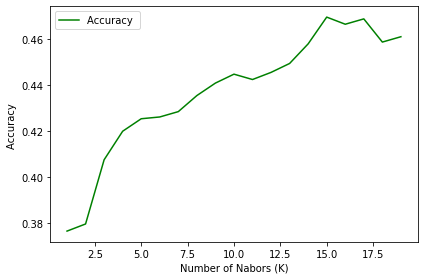

In [8]:
plt.plot(range(1,Ks),knn_mean_acc,'g')
#plt.fill_between(range(1,Ks),knn_mean_acc - 1 * std_acc,knn_mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [11]:
k = 15
#Train Model and Predict  
neigh7 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh7
y_pred = neigh7.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh7.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_pred))

knn_confusion, knn_report = print_model_metrics(y_test, y_pred, genre_list)
knn_cr = pd.DataFrame(knn_report).transpose()
knn_cr['model'] ='knn'
knn_cr
#print(type(confusion), type(class_report))
#print(class_report)

Train set Accuracy:  0.5369649805447471
Test set Accuracy:  0.46967340590979784
Confusion Matrix

[[ 64  22  31   2   5   1  67]
 [  4  57  42   0  13   4  23]
 [ 12  29 181  18  10   4  18]
 [  5   9  39 157   8   4   6]
 [  3  22  62   7  32   1   4]
 [  3  14  41  16   8   8   3]
 [ 49  30  31   1   9   2 105]]

Accuracy: 0.47

Micro Precision: 0.47
Micro Recall: 0.47
Micro F1-score: 0.47

Macro Precision: 0.45
Macro Recall: 0.41
Macro F1-score: 0.41

Weighted Precision: 0.48
Weighted Recall: 0.47
Weighted F1-score: 0.46

Classification Report

                  precision    recall  f1-score   support

Alternative Rock       0.46      0.33      0.39       192
            Rock       0.31      0.40      0.35       143
       Dance Pop       0.42      0.67      0.52       272
         Country       0.78      0.69      0.73       228
             Pop       0.38      0.24      0.30       131
             R&B       0.33      0.09      0.14        93
         Hip Hop       0.46      0.46  

,precision,recall,f1-score,support,model
Alternative Rock,0.457143,0.333333,0.385542,192.000000,knn
Rock,0.311475,0.398601,0.349693,143.000000,knn
Dance Pop,0.423888,0.665441,0.517883,272.000000,knn
Country,0.781095,0.688596,0.731935,228.000000,knn
Pop,0.376471,0.244275,0.296296,131.000000,knn
R&B,0.333333,0.086022,0.136752,93.000000,knn
Hip Hop,0.464602,0.462555,0.463576,227.000000,knn
accuracy,0.469673,0.469673,0.469673,0.469673,knn
macro avg,0.449715,0.411261,0.411668,1286.000000,knn
weighted avg,0.475491,0.469673,0.457652,1286.000000,knn


In [10]:
def print_model_metrics(y_test,y_pred,class_list):
    from sklearn.metrics import confusion_matrix
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix\n')
    print(confusion)

    #importing accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    genre_list = ['Alternative Rock', 'Rock','Dance Pop', 'Country', 'Pop', 'R&B','Hip Hop']
    print('\nClassification Report\n')
    class_report = classification_report(y_test, y_pred, target_names=genre_list, output_dict=True) 
    print(classification_report(y_test, y_pred, target_names=genre_list))
    
    return confusion, class_report

Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
#from sklearn.externals.six import StringIO
#import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
genreTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
genreTree # it shows the default parameters
genreTree.fit(X_train,y_train)
predTree = genreTree.predict(X_test)
#print_model_metrics(y_test, predTree, genre_list)
tree_confusion, tree_report = print_model_metrics(y_test, predTree, genre_list)
tree_cr = pd.DataFrame(tree_report).transpose()
tree_cr['model'] ='tree'
tree_cr
#print (predTree [0:5])
#print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

Confusion Matrix

[[ 34  29  10   9   0  14  96]
 [  1  99  17   4   0   7  15]
 [  2  75 105  42   0  23  25]
 [  0   2  19 177   0  22   8]
 [  2  38  34  25   0  19  13]
 [  0  30  18  22   0  20   3]
 [ 25  46  15   9   0   8 124]]

Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.36
Macro Recall: 0.40
Macro F1-score: 0.36

Weighted Precision: 0.41
Weighted Recall: 0.43
Weighted F1-score: 0.40

Classification Report

                  precision    recall  f1-score   support

Alternative Rock       0.53      0.18      0.27       192
            Rock       0.31      0.69      0.43       143
       Dance Pop       0.48      0.39      0.43       272
         Country       0.61      0.78      0.69       228
             Pop       0.00      0.00      0.00       131
             R&B       0.18      0.22      0.19        93
         Hip Hop       0.44      0.55      0.49       227

        accuracy                           0.43      1286
  

,precision,recall,f1-score,support,model
Alternative Rock,0.531250,0.177083,0.265625,192.000000,tree
Rock,0.310345,0.692308,0.428571,143.000000,tree
Dance Pop,0.481651,0.386029,0.428571,272.000000,tree
Country,0.614583,0.776316,0.686047,228.000000,tree
Pop,0.000000,0.000000,0.000000,131.000000,tree
R&B,0.176991,0.215054,0.194175,93.000000,tree
Hip Hop,0.436620,0.546256,0.485323,227.000000,tree
accuracy,0.434681,0.434681,0.434681,0.434681,tree
macro avg,0.364491,0.399006,0.355473,1286.000000,tree
weighted avg,0.414531,0.434681,0.399302,1286.000000,tree


SVM

In [13]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', gamma= 'auto')
svm_model.fit(X_train, y_train)
svm_yhat = svm_model.predict(X_test)
#print_model_metrics(y_test, svm_yhat, genres)
svm_confusion, svm_report = print_model_metrics(y_test, svm_yhat, genre_list)
svm_cr = pd.DataFrame(svm_report).transpose()
svm_cr['model'] ='svm'
svm_cr

Confusion Matrix

[[ 30   5  48   1   5   0 103]
 [  0  13  65   0  15   0  50]
 [  1   4 218  20  10   0  19]
 [  2   2  48 164   2   0  10]
 [  1   6  81   7  28   0   8]
 [  0   3  62  10   7   0  11]
 [ 14  14  47   2   8   0 142]]

Accuracy: 0.46

Micro Precision: 0.46
Micro Recall: 0.46
Micro F1-score: 0.46

Macro Precision: 0.41
Macro Recall: 0.37
Macro F1-score: 0.35

Weighted Precision: 0.46
Weighted Recall: 0.46
Weighted F1-score: 0.41

Classification Report

                  precision    recall  f1-score   support

Alternative Rock       0.62      0.16      0.25       192
            Rock       0.28      0.09      0.14       143
       Dance Pop       0.38      0.80      0.52       272
         Country       0.80      0.72      0.76       228
             Pop       0.37      0.21      0.27       131
             R&B       0.00      0.00      0.00        93
         Hip Hop       0.41      0.63      0.50       227

        accuracy                           0.46      1286
  

,precision,recall,f1-score,support,model
Alternative Rock,0.625000,0.156250,0.250000,192.000000,svm
Rock,0.276596,0.090909,0.136842,143.000000,svm
Dance Pop,0.383128,0.801471,0.518430,272.000000,svm
Country,0.803922,0.719298,0.759259,228.000000,svm
Pop,0.373333,0.213740,0.271845,131.000000,svm
R&B,0.000000,0.000000,0.000000,93.000000,svm
Hip Hop,0.413994,0.625551,0.498246,227.000000,svm
accuracy,0.462675,0.462675,0.462675,0.462675,svm
macro avg,0.410853,0.372460,0.347803,1286.000000,svm
weighted avg,0.458741,0.462675,0.412446,1286.000000,svm


Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
log_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs',multi_class='ovr')).fit(X_train, y_train)
log_yhat = log_model.predict(X_test)
#print_model_metrics(y_test, log_yhat, genre_list)
log_confusion, log_report = print_model_metrics(y_test, log_yhat, genre_list)
log_cr = pd.DataFrame(log_report).transpose()
log_cr['model'] ='log'
log_cr

Confusion Matrix

[[ 39   5  41   4   3   0 100]
 [  0  15  57   0  21   0  50]
 [  3   3 200  26  17   0  23]
 [  2   1  36 173   4   0  12]
 [  3   6  73  16  27   1   5]
 [  0   3  40  18  16   2  14]
 [ 19  14  48   3   4   0 139]]

Accuracy: 0.46

Micro Precision: 0.46
Micro Recall: 0.46
Micro F1-score: 0.46

Macro Precision: 0.49
Macro Recall: 0.38
Macro F1-score: 0.36

Weighted Precision: 0.49
Weighted Recall: 0.46
Weighted F1-score: 0.42

Classification Report

                  precision    recall  f1-score   support

Alternative Rock       0.59      0.20      0.30       192
            Rock       0.32      0.10      0.16       143
       Dance Pop       0.40      0.74      0.52       272
         Country       0.72      0.76      0.74       228
             Pop       0.29      0.21      0.24       131
             R&B       0.67      0.02      0.04        93
         Hip Hop       0.41      0.61      0.49       227

        accuracy                           0.46      1286
  

,precision,recall,f1-score,support,model
Alternative Rock,0.590909,0.203125,0.302326,192.000000,log
Rock,0.319149,0.104895,0.157895,143.000000,log
Dance Pop,0.404040,0.735294,0.521512,272.000000,log
Country,0.720833,0.758772,0.739316,228.000000,log
Pop,0.293478,0.206107,0.242152,131.000000,log
R&B,0.666667,0.021505,0.041667,93.000000,log
Hip Hop,0.405248,0.612335,0.487719,227.000000,log
accuracy,0.462675,0.462675,0.462675,0.462675,log
macro avg,0.485761,0.377433,0.356084,1286.000000,log
weighted avg,0.486609,0.462675,0.417846,1286.000000,log


K Means Clustering

In [23]:
from sklearn.cluster import KMeans
clusterNum = 7
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
df["Clus_km"] = labels
df.head(5)
df.groupby('Clus_km').agg(['mean','count'])

energy        liveness           tempo         valence        \
             mean count      mean count      mean count      mean count   
Clus_km                                                                   
0        0.777679   468  0.477577   468  0.385877   468  0.623618   468   
1        0.580150   642  0.158940   642  0.418402   642  0.673813   642   
2        0.799740   801  0.175143   801  0.677355   801  0.534526   801   
3        0.619967  1125  0.147752  1125  0.385977  1125  0.327038  1125   
4        0.731233  1370  0.135507  1370  0.388206  1370  0.751495  1370   
5        0.726274   219  0.194900   219  0.461864   219  0.473160   219   
6        0.361105   516  0.144805   516  0.424671   516  0.314720   516   

         loudness       speechiness       acousticness       danceability  \
             mean count        mean count         mean count         mean   
Clus_km                                                                     
0        0.726746   468    0.122437   468     0.096379   468     0.625184   
1        0.628865   642    0.097646   642     0.424511   642     0.675692   
2        0.740414   801    0.091057   801     0.063901   801     0.473782   
3        0.690468  1125    0.079053  1125     0.117287  1125     0.607239   
4        0.711946  1370    0.112536  1370     0.080831  1370     0.728587   
5        0.637892   219    0.058907   219     0.087669   219     0.493578   
6        0.559967   516    0.057244   516     0.680610   516     0.532099   

              instrumentalness       genre_num        
        count             mean count      mean count  
Clus_km                                               
0         468         0.009198   468  3.074786   468  
1         642         0.007727   642  3.183801   642  
2         801         0.014237   801  2.972534   801  
3        1125         0.011405  1125  2.961778  1125  
4        1370         0.011005  1370  2.867883  1370  
5         219         0.651886   219  1.931507   219  
6         516         0.023305   516  3.042636   516

In [24]:
df.groupby(['genre_num']).mean()

,energy,liveness,tempo,valence,loudness,speechiness,acousticness,danceability,instrumentalness,Clus_km
genre_num,,,,,,,,,,
0,0.715664,0.183746,0.475549,0.514820,0.653595,0.052622,0.134299,0.479520,0.157626,3.216450
1,0.619126,0.164200,0.468332,0.570899,0.663574,0.038809,0.285192,0.589330,0.001843,3.042179
2,0.698526,0.175791,0.441852,0.567787,0.746211,0.080057,0.152656,0.671757,0.015897,2.944105
3,0.672725,0.215747,0.379366,0.601794,0.674387,0.225596,0.143004,0.750496,0.017986,2.690236
4,0.564664,0.154855,0.442264,0.441975,0.704842,0.080580,0.339964,0.631561,0.006697,3.464029
5,0.566994,0.156410,0.406671,0.536849,0.663046,0.090154,0.235481,0.674050,0.003355,3.141667
6,0.707787,0.192470,0.480947,0.549244,0.648662,0.053933,0.162420,0.507603,0.058169,2.702265


In [26]:
#df.groupby(["Group", "Size"]).size()
counts = df.groupby(['genre', 'Clus_km']).size()
#cross_counts = pd.DataFrame(columns = [0,1,2,3,4,5,6], index = genre_list)
counts['Country',5] = 0
cross_counts = []
for j in range(len(genre_list)):
    row = []
    row.append(genre_list[j])
    for i in range(0,7):
        temp = int(counts.loc[genre_list[j], i])
        row.append(temp)
    cross_counts.append(row)
cc_df = pd.DataFrame(cross_counts, columns = ['genre',0,1,2,3,4,5,6])
cc_df

,genre,0,1,2,3,4,5,6
0,Alternative Rock,45,39,179,132,112,128,58
1,Rock,92,124,249,164,171,55,72
2,Dance Pop,110,110,140,293,415,20,57
3,Country,33,114,91,105,118,0,108
4,Pop,28,75,60,150,87,3,153
5,R&B,21,63,15,107,103,1,50
6,Hip Hop,139,117,67,174,364,12,18


Confusion Matrixes of all models

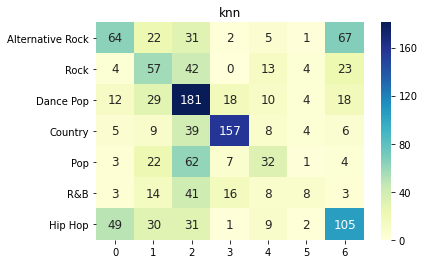

<Figure size 576x360 with 0 Axes>

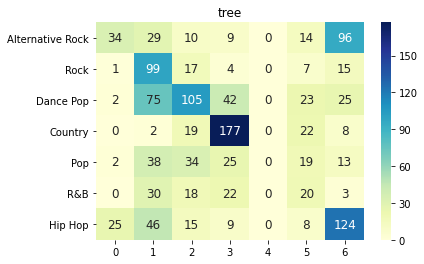

<Figure size 576x360 with 0 Axes>

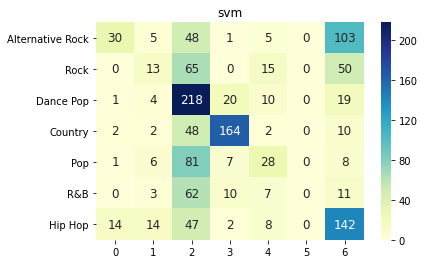

<Figure size 576x360 with 0 Axes>

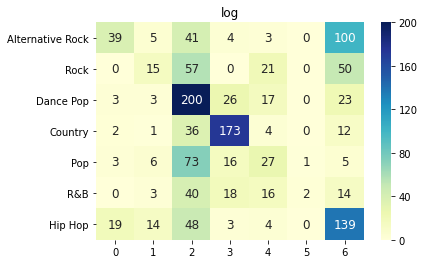

<Figure size 576x360 with 0 Axes>

In [15]:
import seaborn as sn
def plot_cm(cm, names, title):
    cm = pd.DataFrame(cm, index = names)
    ax = plt.axes()
    plt.figure(figsize = (8,5))
    sn.heatmap(cm, ax = ax, annot=True, fmt = '.3g', annot_kws={"size": 12}, cmap="YlGnBu")
    ax.set_title(title)
    plt.show()

plot_cm(knn_confusion, genre_list, 'knn')
plot_cm(tree_confusion, genre_list, 'tree')
plot_cm(svm_confusion, genre_list, 'svm')
plot_cm(log_confusion, genre_list, 'log')

In [16]:
frames = [knn_cr, svm_cr, tree_cr, log_cr]
all_cr = pd.concat(frames)
all_cr.drop('support', axis =1, inplace=True)
agg_metrics = ['accuracy','macro avg', 'weighted avg']
agg_cr = all_cr[all_cr.index.isin(agg_metrics)]
genre_cr = all_cr[all_cr.index.isin(genre_list)]

In [17]:
agg_cr
agg_cr.sort_values('f1-score', ascending = False)

,precision,recall,f1-score,model
accuracy,0.469673,0.469673,0.469673,knn
accuracy,0.462675,0.462675,0.462675,svm
accuracy,0.462675,0.462675,0.462675,log
weighted avg,0.475491,0.469673,0.457652,knn
accuracy,0.434681,0.434681,0.434681,tree
weighted avg,0.486609,0.462675,0.417846,log
weighted avg,0.458741,0.462675,0.412446,svm
macro avg,0.449715,0.411261,0.411668,knn
weighted avg,0.414531,0.434681,0.399302,tree
macro avg,0.485761,0.377433,0.356084,log


In [18]:
genre_cr.sort_values(['f1-score'], ascending = False)

,precision,recall,f1-score,model
Country,0.803922,0.719298,0.759259,svm
Country,0.720833,0.758772,0.739316,log
Country,0.781095,0.688596,0.731935,knn
Country,0.614583,0.776316,0.686047,tree
Dance Pop,0.404040,0.735294,0.521512,log
Dance Pop,0.383128,0.801471,0.518430,svm
Dance Pop,0.423888,0.665441,0.517883,knn
Hip Hop,0.413994,0.625551,0.498246,svm
Hip Hop,0.405248,0.612335,0.487719,log
Hip Hop,0.436620,0.546256,0.485323,tree


In [19]:
genre_cr.groupby(genre_cr.index).max()

,precision,recall,f1-score,model
Alternative Rock,0.625000,0.333333,0.385542,tree
Country,0.803922,0.776316,0.759259,tree
Dance Pop,0.481651,0.801471,0.521512,tree
Hip Hop,0.464602,0.625551,0.498246,tree
Pop,0.376471,0.244275,0.296296,tree
R&B,0.666667,0.215054,0.194175,tree
Rock,0.319149,0.692308,0.428571,tree


In [20]:
genre_cr.groupby(genre_cr.index).agg(['min','max','mean'])
#df.groupby('Clus_km').agg(['mean','count'])

precision                        recall                      \
                       min       max      mean       min       max      mean   
Alternative Rock  0.457143  0.625000  0.551075  0.156250  0.333333  0.217448   
Country           0.614583  0.803922  0.730108  0.688596  0.776316  0.735746   
Dance Pop         0.383128  0.481651  0.423177  0.386029  0.801471  0.647059   
Hip Hop           0.405248  0.464602  0.430116  0.462555  0.625551  0.561674   
Pop               0.000000  0.376471  0.260821  0.000000  0.244275  0.166031   
R&B               0.000000  0.666667  0.294248  0.000000  0.215054  0.080645   
Rock              0.276596  0.319149  0.304391  0.090909  0.692308  0.321678   

                  f1-score                      
                       min       max      mean  
Alternative Rock  0.250000  0.385542  0.300873  
Country           0.686047  0.759259  0.729139  
Dance Pop         0.428571  0.521512  0.496599  
Hip Hop           0.463576  0.498246  0.483716  
Pop               0.000000  0.296296  0.202573  
R&B               0.000000  0.194175  0.093148  
Rock              0.136842  0.428571  0.268250

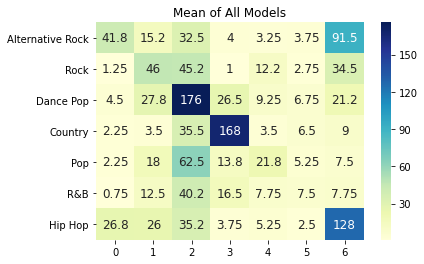

<Figure size 576x360 with 0 Axes>

In [21]:
all_confusion = (knn_confusion + tree_confusion + svm_confusion + log_confusion)/4
plot_cm(all_confusion, genre_list, 'Mean of All Models')


noticed variation in models dependent upon sample split, 
so decided to try decision tree model (marginally best performer)
on current train/test split.  Not enough data to create unique segments, 
to create train/test split, so I randomly split the data using a 80/20 
multiple times to compare results

# ==============================================================================
Decision tree
               0    1    2    3    4    5    6    7    8    9    ...  90   91   \
Alt          0.40 0.38 0.32 0.33 0.41 0.24 0.40 0.41 0.39 0.47  ... 0.41 0.32   
Rock         0.43 0.42 0.43 0.42 0.45 0.40 0.37 0.43 0.43 0.40  ... 0.45 0.45   
Dance        0.43 0.41 0.44 0.43 0.45 0.41 0.40 0.42 0.43 0.39  ... 0.39 0.44   
Country      0.72 0.70 0.67 0.72 0.68 0.72 0.69 0.74 0.73 0.71  ... 0.71 0.73   
Pop          0.00 0.08 0.00 0.09 0.05 0.00 0.00 0.00 0.07 0.00  ... 0.00 0.00   
R&B          0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00  ... 0.00 0.00   
Hip Hop      0.48 0.40 0.42 0.48 0.49 0.48 0.46 0.51 0.56 0.51  ... 0.47 0.46   
Accuracy     0.45 0.42 0.42 0.45 0.45 0.43 0.43 0.46 0.47 0.45  ... 0.45 0.44   
Macro Avg    0.35 0.34 0.33 0.35 0.36 0.32 0.33 0.36 0.37 0.35  ... 0.35 0.34   
Weighted Avg 0.41 0.39 0.37 0.41 0.42 0.38 0.39 0.42 0.44 0.41  ... 0.40 0.39   

            

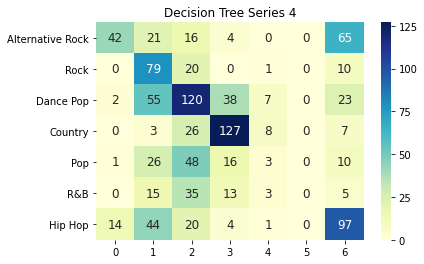

<Figure size 576x360 with 0 Axes>

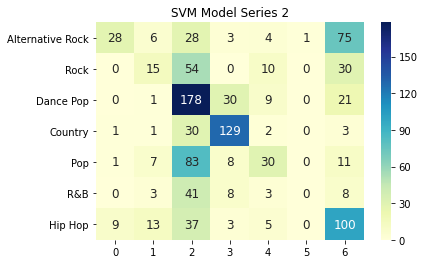

<Figure size 576x360 with 0 Axes>

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')

def svm_model(X_train, X_test, y_train, y_test, genre_list): 
    model = svm.SVC(kernel='rbf', gamma= 'auto')
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    confusion, report = model_metrics(y_test, yhat, genre_list)
    cr = pd.DataFrame(report).transpose()
    f1_scores = cr['f1-score'].to_list()
    return confusion, f1_scores

def mc_log_model(X_train, X_test, y_train, y_test, genre_list):
    model = OneVsRestClassifier(LogisticRegression(solver='lbfgs',multi_class='ovr')).fit(X_train, y_train)
    yhat = model.predict(X_test)
    confusion, report = model_metrics(y_test, yhat, genre_list)
    cr = pd.DataFrame(report).transpose()
    f1_scores = cr['f1-score'].to_list()
    return confusion, f1_scores

def decision_tree(X_train, X_test, y_train, y_test, genre_list):
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
    Tree # it shows the default parameters
    Tree.fit(X_train,y_train)
    predTree = Tree.predict(X_test)
    confusion, report = model_metrics(y_test, predTree, genre_list)
    cr = pd.DataFrame(report).transpose()
    f1_scores =cr['f1-score'].to_list()

    return confusion, f1_scores

def generate_train_test_splits(df):
    X_cols = [ "energy", "liveness", "tempo", "valence", "loudness", "speechiness", "acousticness", "danceability", "instrumentalness"]
    genre_list = ['Alternative Rock', 'Rock','Dance Pop', 'Country', 'Pop', 'R&B','Hip Hop']
    Y = df.drop(X_cols, axis =1)
    X = df.filter(X_cols, axis=1)
    Y2_cols = (genre_list, 'genre_num')
    X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2)
    y_test = y_test['genre_num']
    y_train = y_train['genre_num']
    return X_train, X_test, y_train, y_test

def model_metrics(y_test,y_pred,class_list):
    confusion = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=genre_list, output_dict=True) 
#    print(classification_report(y_test, y_pred, target_names=class_list))
    return confusion, class_report


df1 = pd.read_csv('final_data.csv', index_col = 'id')
index_list = ['Alt', 'Rock', 'Dance','Country', 'Pop', 'R&B', 'Hip Hop', 'Accuracy','Macro Avg', 'Weighted Avg']
l_series_f1 = pd.DataFrame(index = index_list)
t_series_f1 = pd.DataFrame(index = index_list)
s_series_f1 = pd.DataFrame(index = index_list)
t_series_cm = []
l_series_cm = []
s_series_cm = []

for i in range(100):
    X_tr1, X_te1, y_tr1, y_te1 = generate_train_test_splits(df1)
    t_cm, t_f1 = decision_tree(X_tr1, X_te1, y_tr1, y_te1, genre_list)
    t_series_f1[str(i)] = t_f1
    t_series_cm.append(t_cm)
    l_cm, l_f1 = mc_log_model(X_tr1, X_te1, y_tr1, y_te1, genre_list)
    l_series_f1[i] = l_f1
    l_series_cm.append(l_cm)
    s_cm, s_f1 = svm_model(X_tr1, X_te1, y_tr1, y_te1, genre_list)
    s_series_f1[i] = s_f1
    s_series_cm.append(s_cm)

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.colheader_justify","left")
print("# {}".format('=' * 78))
print('Decision tree\n', t_series_f1)
print("# {}".format('=' * 78))
print('Logristic\n', l_series_f1)
print("# {}".format('=' * 78))
print('SVM Model\n', s_series_f1)
print("# {}".format('=' * 78))

plot_cm(t_series_cm[4], genre_list, 'Decision Tree Series 4')
plot_cm(s_series_cm[2],genre_list, 'SVM Model Series 2')


In [24]:
t_min = t_series_f1.min(axis =1).to_list()
t_max = t_series_f1.max(axis =1).to_list()
t_mean = t_series_f1.mean(axis =1).to_list()
l_min = l_series_f1.min(axis =1).to_list()
l_max = l_series_f1.max(axis =1).to_list()
l_mean = l_series_f1.mean(axis =1).to_list()
s_min = s_series_f1.min(axis =1).to_list()
s_max = s_series_f1.max(axis =1).to_list()
s_mean = s_series_f1.mean(axis =1).to_list()


In [25]:
all_series_f1 = pd.DataFrame(index = index_list)
all_series_f1['Tree Min'] = t_min
all_series_f1['Tree Max'] = t_max
all_series_f1['Tree Mean'] = t_mean
all_series_f1['Tree Delta'] = all_series_f1['Tree Max'] - all_series_f1['Tree Min']
all_series_f1['Log Min'] = l_min
all_series_f1['Log Max'] = l_max
all_series_f1['Log Mean'] = l_mean
all_series_f1['Log Delta'] = all_series_f1['Log Max'] - all_series_f1['Log Min']
all_series_f1['SVM Min'] = s_min
all_series_f1['SVM Max'] = s_max
all_series_f1['SVM Mean'] = s_mean
all_series_f1['SVM Delta'] = all_series_f1['SVM Max'] - all_series_f1['SVM Min']

all_series_f1

,Tree Min,Tree Max,Tree Mean,Tree Delta,Log Min,Log Max,Log Mean,Log Delta,SVM Min,SVM Max,SVM Mean,SVM Delta
Alt,0.22,0.50,0.38,0.28,0.26,0.42,0.34,0.17,0.18,0.41,0.28,0.23
Rock,0.24,0.49,0.41,0.25,0.09,0.26,0.17,0.17,0.08,0.26,0.17,0.18
Dance,0.36,0.50,0.42,0.14,0.46,0.57,0.51,0.11,0.46,0.56,0.51,0.10
Country,0.63,0.76,0.71,0.12,0.67,0.79,0.74,0.12,0.68,0.80,0.74,0.12
Pop,0.00,0.15,0.01,0.15,0.23,0.38,0.30,0.16,0.20,0.38,0.30,0.19
R&B,0.00,0.18,0.01,0.18,0.00,0.09,0.02,0.09,0.00,0.00,0.00,0.00
Hip Hop,0.38,0.56,0.47,0.18,0.41,0.58,0.50,0.17,0.43,0.58,0.51,0.15
Accuracy,0.40,0.48,0.44,0.08,0.44,0.52,0.47,0.08,0.44,0.52,0.47,0.08
Macro Avg,0.31,0.38,0.34,0.07,0.34,0.41,0.37,0.07,0.33,0.39,0.36,0.06
Weighted Avg,0.36,0.44,0.40,0.08,0.40,0.48,0.43,0.08,0.39,0.47,0.42,0.08


tree ['20', '93', '93', '56', '65', '39', '8', '93', '19', '8']
log [38, 29, 20, 56, 94, 28, 80, 80, 80, 80]


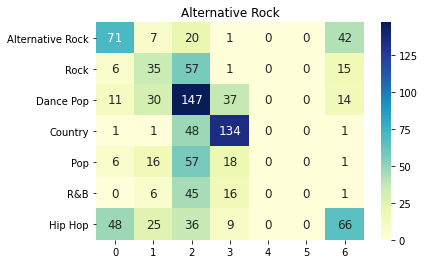

<Figure size 576x360 with 0 Axes>

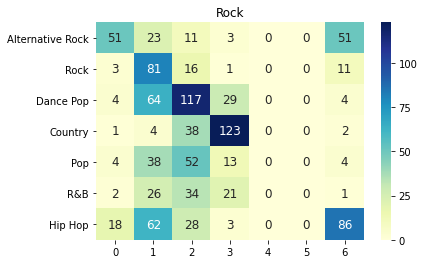

<Figure size 576x360 with 0 Axes>

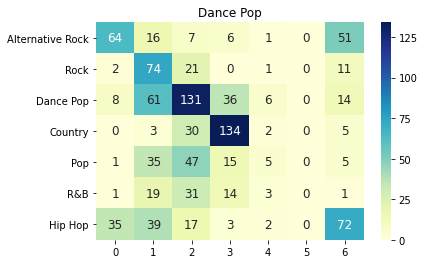

<Figure size 576x360 with 0 Axes>

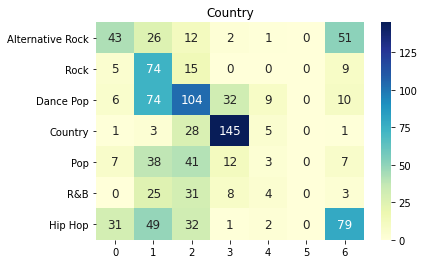

<Figure size 576x360 with 0 Axes>

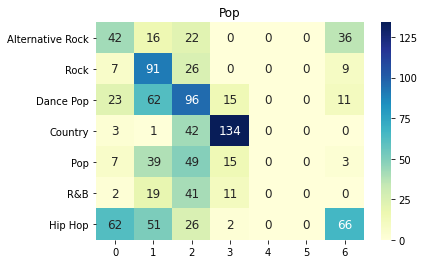

<Figure size 576x360 with 0 Axes>

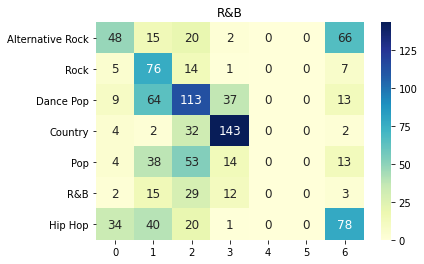

<Figure size 576x360 with 0 Axes>

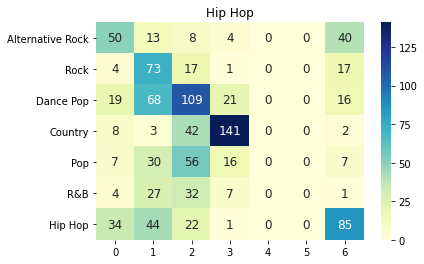

<Figure size 576x360 with 0 Axes>

In [26]:
t_id_max = t_series_f1.idxmax(axis =1).to_list()
print('tree', t_id_max)
l_id_max = l_series_f1.idxmax(axis =1).to_list()
print('log', l_id_max)
for i in range(7):
    plot_cm(t_series_cm[l_id_max[i]], genre_list, genre_list[i])

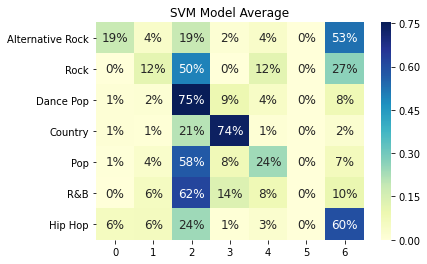

<Figure size 1152x720 with 0 Axes>

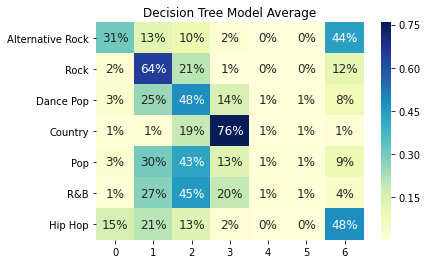

<Figure size 1152x720 with 0 Axes>

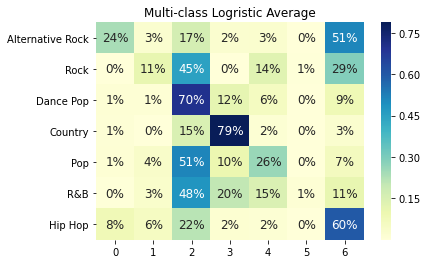

<Figure size 1152x720 with 0 Axes>

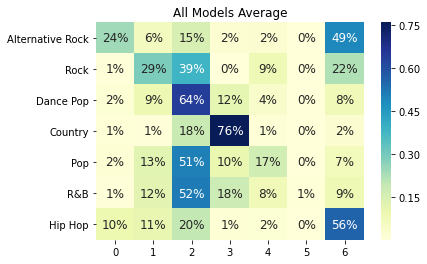

<Figure size 1152x720 with 0 Axes>

In [62]:
def plot_cm_percent(cm, names, title):
    cm = pd.DataFrame(cm, index = names)
    ax = plt.axes()
    plt.figure(figsize = (16,10))
    sn.heatmap(cm, ax = ax, annot=True, fmt = '.0%', annot_kws={"size": 12}, cmap="YlGnBu")
    ax.set_title(title)
    plt.show()

s_all_cm = np.zeros(shape=(7,7))
t_all_cm = np.zeros(shape=(7,7))
l_all_cm = np.zeros(shape=(7,7))
for i in range(len(s_series_cm)):
    s_all_cm = s_all_cm + s_series_cm[i]
    t_all_cm = t_all_cm + t_series_cm[i]
    l_all_cm = l_all_cm + l_series_cm[i]
s_all_cm = s_all_cm/len(s_series_cm)
t_all_cm = t_all_cm/len(t_series_cm)
l_all_cm = l_all_cm/len(l_series_cm)
all_cm = (s_all_cm+t_all_cm+l_all_cm)/3


s_all_sum = np.sum(s_all_cm, axis=1, keepdims=True)
s_all_perc = s_all_cm / s_all_sum.astype(float)
t_all_sum = np.sum(t_all_cm, axis=1, keepdims=True)
t_all_perc = t_all_cm / t_all_sum.astype(float)
l_all_sum = np.sum(l_all_cm, axis=1, keepdims=True)
l_all_perc = l_all_cm / l_all_sum.astype(float)
all_sum = np.sum(all_cm, axis=1, keepdims=True)
all_perc = all_cm / all_sum.astype(float)


plot_cm_percent(s_all_perc, genre_list, 'SVM Model Average')
plot_cm_percent(t_all_perc, genre_list, 'Decision Tree Model Average')
plot_cm_percent(l_all_perc, genre_list, 'Multi-class Logristic Average')
plot_cm_percent(all_perc, genre_list, 'All Models Average')